In [1]:
import numpy as np
import pandas as pd
from collections import Counter

In [2]:
data = {
    'outlook': ['sunny', 'sunny', 'overcast', 'rainy', 'rainy', 'rainy', 'overcast', 'sunny', 'sunny', 'rainy', 'sunny', 'overcast', 'overcast', 'rainy'],
    'temp':    ['hot'  , 'hot'  , 'hot'     , 'mild', 'cool', 'cool', 'cool', 'mild', 'cool', 'mild', 'mild', 'mild', 'hot', 'mild'],
    'humidity': ['high', 'high', 'high', 'high', 'normal', 'normal', 'normal', 'high', 'normal', 'normal', 'normal', 'high', 'normal', 'high'],
    'windy': [False, True, False, False, False, True, True, False, False, False, True, True, False, True],
    'play': ['no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no']
}
df = pd.DataFrame(data)
df

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [3]:
encoders = {}
for column in df.columns:
    df[column] = df[column].astype('category')
    encoders[column] = dict(enumerate(df[column].cat.categories))
    df[column] = df[column].cat.codes

# Convert DataFrame to list of lists
dataset = df.values.tolist()
dataset

[[2, 1, 0, 0, 0],
 [2, 1, 0, 1, 0],
 [0, 1, 0, 0, 1],
 [1, 2, 0, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 1, 0],
 [0, 0, 1, 1, 1],
 [2, 2, 0, 0, 0],
 [2, 0, 1, 0, 1],
 [1, 2, 1, 0, 1],
 [2, 2, 1, 1, 1],
 [0, 2, 0, 1, 1],
 [0, 1, 1, 0, 1],
 [1, 2, 0, 1, 0]]

In [17]:
def gini_index(groups, classes):
    n_instances = sum([len(group) for group in groups])
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0.0
        # Gini index formula = 1 - sum(proportion^2)
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            print("G:",group," class_val",class_val,"g:",p**2)
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

def entropy(column):
    counts = Counter(column)
    probabilities = [count / len(column) for count in counts.values()]
    # Entropy Formula = -sum(p1 * log2(p1) + p2 * log2(p2) + ... + pn * log2(pn))
    entropy = -sum(p * np.log2(p) for p in probabilities)
    return entropy

def information_gain(entropy_parent, entropy_children, weights):
    weighted_entropy_children = sum(entropy * weight for entropy, weight in zip(entropy_children, weights))
    information_gain = entropy_parent - weighted_entropy_children
    return information_gain

def calculate_entropy_gini(df):
    columns = df.columns[:-1]
    classes = df[df.columns[-1]].unique()
    main_entropy = entropy(df[df.columns[-1]])
    entropy_dict = {}
    gini_dict = {}
    information_gains = {}

    # Calculate entropy and Gini index for each feature
    for column in columns:
        entropy_dict[column] = entropy(df[column])
        groups = df.groupby(column)
        gini_dict[column] = gini_index([groups.get_group(x).values.tolist() for x in groups.groups], classes)
    
    # Calculate information gain for each feature
    entropy_parent = entropy(df[df.columns[-1]])
    for column in columns:
        groups = df.groupby(column)
        entropy_children = [entropy(df[df[column] == value][df.columns[-1]]) for value in groups.groups]
        #print(column, entropy_children)
        weights = [df[df[column] == value].shape[0]/len(df) for value in groups.groups]
        #print(column, weights)
        information_gains[column] = information_gain(entropy_parent, entropy_children, weights)

    return information_gains, entropy_dict, gini_dict, main_entropy


In [18]:
information_gains,entropy_dict, gini_dict, main_entropy = calculate_entropy_gini(df)
print("Main Entropy:", main_entropy)
print("Information gain for each column:", information_gains)
print("Gain",{k: main_entropy - v for k, v in information_gains.items()})
print("Entropy for each column:", entropy_dict)
print("Gini index for each column:", gini_dict)

G: [[0, 1, 0, 0, 1], [0, 0, 1, 1, 1], [0, 2, 0, 1, 1], [0, 1, 1, 0, 1]]  class_val 0 p: 0.0
G: [[0, 1, 0, 0, 1], [0, 0, 1, 1, 1], [0, 2, 0, 1, 1], [0, 1, 1, 0, 1]]  class_val 1 p: 1.0
G: [[1, 2, 0, 0, 1], [1, 0, 1, 0, 1], [1, 0, 1, 1, 0], [1, 2, 1, 0, 1], [1, 2, 0, 1, 0]]  class_val 0 p: 0.16000000000000003
G: [[1, 2, 0, 0, 1], [1, 0, 1, 0, 1], [1, 0, 1, 1, 0], [1, 2, 1, 0, 1], [1, 2, 0, 1, 0]]  class_val 1 p: 0.36
G: [[2, 1, 0, 0, 0], [2, 1, 0, 1, 0], [2, 2, 0, 0, 0], [2, 0, 1, 0, 1], [2, 2, 1, 1, 1]]  class_val 0 p: 0.36
G: [[2, 1, 0, 0, 0], [2, 1, 0, 1, 0], [2, 2, 0, 0, 0], [2, 0, 1, 0, 1], [2, 2, 1, 1, 1]]  class_val 1 p: 0.16000000000000003
G: [[1, 0, 1, 0, 1], [1, 0, 1, 1, 0], [0, 0, 1, 1, 1], [2, 0, 1, 0, 1]]  class_val 0 p: 0.0625
G: [[1, 0, 1, 0, 1], [1, 0, 1, 1, 0], [0, 0, 1, 1, 1], [2, 0, 1, 0, 1]]  class_val 1 p: 0.5625
G: [[2, 1, 0, 0, 0], [2, 1, 0, 1, 0], [0, 1, 0, 0, 1], [0, 1, 1, 0, 1]]  class_val 0 p: 0.25
G: [[2, 1, 0, 0, 0], [2, 1, 0, 1, 0], [0, 1, 0, 0, 1], [0, 1, 1

In [6]:
def print_step_info(node, df):
    information_gains, entropies, ginis, __ = calculate_entropy_gini(df)
    print("Step Information:")
    print("Splitting on feature {} with value {}".format(node['index'], node['value']))
    print("Information Gains:", information_gains)
    print("Entropies:", entropies)
    print("Gini Indices:", ginis)
    print("x"*50)

In [7]:
def build_tree(train, max_depth, min_size,columns,target):
    columns.append(target)
    root = get_split(train,columns)
    split(root, max_depth, min_size, 1,columns)
    return root

def get_split(dataset,columns):
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_value, best_score, best_groups = -1, -1, 99999, None
    df = pd.DataFrame(dataset, columns=columns)
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = group_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    node = {'index': best_index, 'value': best_value, 'groups': best_groups, 'best_score': best_score}
    print_step_info(node, df)
    return node

def group_split(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def root_(group):
    outcomes = [row[-1] for row in group]
    return Counter(outcomes).most_common(1)[0][0]

def split(node, max_depth, min_size, depth,columns):
    left, right = node['groups']
    del(node['groups'])
    
    if not left or not right:
        node['left'] = node['right'] = root_(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = root_(left), root_(right)
        return
    

    if len(left) <= min_size:
        node['left'] = root_(left)
    else:
        node['left'] = get_split(left,columns)
        split(node['left'], max_depth, min_size, depth+1,columns)

    
    if len(right) <= min_size:
        node['right'] = root_(right)
    else:
        node['right'] = get_split(right,columns)
        split(node['right'], max_depth, min_size, depth+1,columns)
    

def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

def multi_predict(tree,dataset):
    return [predict(tree, row) for row in dataset]

# Will continue to improve the code
def print_tree(node, depth=0, encoders=None):
    # if true then go to left else go to right
    if isinstance(node, dict):
        if encoders:
            feature_name = list(encoders.keys())[node['index']]
            feature_value = encoders[feature_name][node['value']]
            print('{}[{} < {}]'.format(depth*'\t', feature_name, feature_value))
        else:
            print('{}[X{} < {}]'.format(depth*'\t', node['index'], node['value']))
        
        print_tree(node['left'], depth+1, encoders)
        print_tree(node['right'], depth+1, encoders)
    else:
        if encoders:
            print('{}[{}]'.format(depth*'\t', encoders[list(encoders.keys())[-1]][node]))
        else:
            print('{}[{}]'.format(depth*'\t', node))


In [8]:
max_depth = 3
min_size = 1
columns = df.columns[:-1].to_list()
target = df.columns[-1]
tree = build_tree(dataset, max_depth, min_size, columns, target)
predictions = multi_predict(tree, dataset)
actual = [row[-1] for row in dataset]
accuracy = sum(1 for i in range(len(actual)) if actual[i] == predictions[i]) / len(actual)
print(f'Accuracy: {accuracy * 100:.2f}%')

Step Information:
Splitting on feature 0 with value 1
Information Gains: {'outlook': 0.24674981977443933, 'temp': 0.02922256565895487, 'humidity': 0.15183550136234159, 'windy': 0.04812703040826949}
Entropies: {'outlook': 1.5774062828523454, 'temp': 1.5566567074628228, 'humidity': 1.0, 'windy': 0.9852281360342515}
Gini Indices: {'outlook': 0.34285714285714286, 'temp': 0.44047619047619047, 'humidity': 0.3673469387755103, 'windy': 0.42857142857142855}
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Step Information:
Splitting on feature 0 with value 0
Information Gains: {'outlook': -0.0, 'temp': -0.0, 'humidity': -0.0, 'windy': -0.0}
Entropies: {'outlook': -0.0, 'temp': 1.5, 'humidity': 1.0, 'windy': 1.0}
Gini Indices: {'outlook': 0.0, 'temp': 0.0, 'humidity': 0.0, 'windy': 0.0}
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Step Information:
Splitting on feature 2 with value 1
Information Gains: {'outlook': 0.02904940554533142, 'temp': 0.23903595255631882, 'humidity': 0.2780719051

In [9]:
print_tree(tree,3)

			[X0 < 1]
				[X0 < 0]
					[1]
					[1]
				[X2 < 1]
					[X0 < 2]
						[1]
						[0]
					[X3 < 1]
						[1]
						[0]


In [10]:
encoders

{'outlook': {0: 'overcast', 1: 'rainy', 2: 'sunny'},
 'temp': {0: 'cool', 1: 'hot', 2: 'mild'},
 'humidity': {0: 'high', 1: 'normal'},
 'windy': {0: False, 1: True},
 'play': {0: 'no', 1: 'yes'}}

In [11]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
"""
criterion: Literal['gini', 'entropy', 'log_loss'] = "gini",
splitter: Literal['best', 'random'] = "best",
max_depth: Int | None = None,
min_samples_split: float | int = 2,
min_samples_leaf: float | int = 1,
min_weight_fraction_leaf: Float = 0,
max_features: float | int | Literal['auto', 'sqrt', 'log2'] | None = None,
random_state: Int | None = None,
max_leaf_nodes: Int | None = None,
min_impurity_decrease: Float = 0,
class_weight: Mapping | str | Sequence[Mapping] | None = None,
ccp_alpha: float = 0
"""
tree = DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1)
tree.fit(df.drop('play', axis=1), df['play'])
predictions = tree.predict(df.drop('play', axis=1))

accuracy = sum(1 for i in range(len(actual)) if actual[i] == predictions[i]) / len(actual)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 85.71%


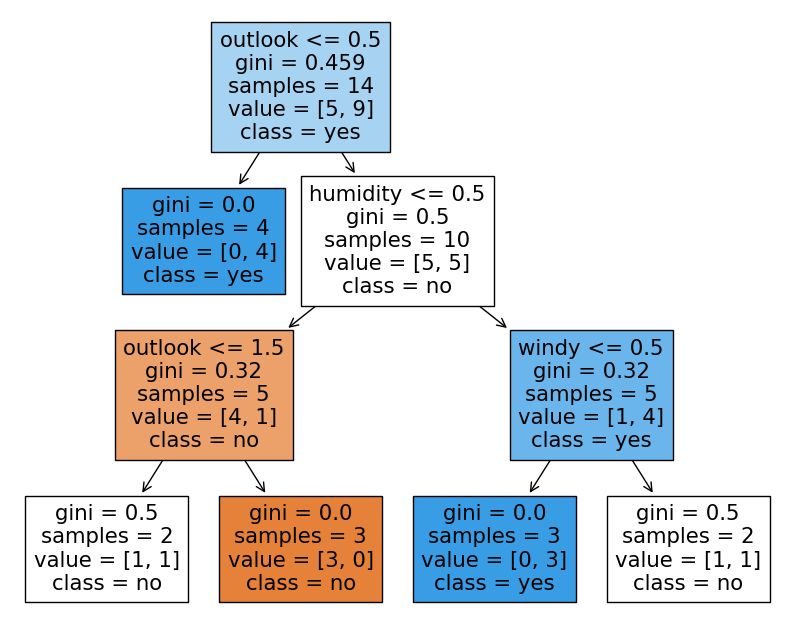

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
class_names = [encoders['play'][i] for i in range(len(encoders['play']))]
feature_names = list(df.columns)
plot_tree(tree, feature_names=feature_names, class_names=class_names, filled=True)
plt.show()